In [1]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import random

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Part 1: Load/Analyze Data

##What is your dataset? Please describe your dataset and where you got it

My dataset is from https://github.com/bananathrowingmachine/FastPartitionExperimentDocs/tree/main/Previous%20Results/Full%20Runs which is some saved data generated from a personal project a wrote in May, which I made just to see if I could make a really fast algorith that solves the psuedo-polynomial time partition problem, at least compared to the solution found on Wikipedia (which I did infact beat quite well). The data essentially has 3 x variables and a y variable, where the x variables are the algorithm type (with there being 4 types, the Wikipedia solution, one change I made, another change I made, and then both changes combined together), the amount of integers in the set, and the approximate sum of the set and then the y variable is the average amount of iterations each method took to solve the same randomly(-ish) generated set. For more information on how the experiment was run as a whole you can look here: https://github.com/bananathrowingmachine/FastPartitionExperiment

For this project the data is just linked directly to where it's stored on GitHub with the argument raw=true so that it doesn't redirect to the human visiable page.

How I convert the data is I will turn every combination of inputs and results into a single long list, where the first variable will denote if the data comes from a Memoized algorithm (signified as 1) or a Tabulated algorithm (signified as 0), the second variable will denote if the date comes from a "Crazy" algorithm (signified as 1, with the main GitHub repo elaborating on what "Crazy" means), or a "Normal" algorithm (signified as 0), the third variable will be the "Sum Target" (also elaborated on in the main GitHub repository) and the fourth variable will be the integer count.

Due to my data being available publicly on my Github, the direct links to the sheets already in the code are sufficient for accessing the necessary data frames and vstack them all into a numpy array.

##Load your dataset / Implement your dataloader

In [3]:
def processSheet(fileName: str):
    sheet = pd.ExcelFile(fileName)
    processedData = []
    for sheetName in sheet.sheet_names:
        if sheetName not in ['Recursive Normal', 'Absolute Target Sum']:
            df = pd.read_excel(sheet, sheet_name=sheetName)
            dfReset = df.reset_index().rename(columns={'index': 'Row_Index'})
            dfLong = dfReset.melt(id_vars=['Row_Index'], var_name='Col_Index', value_name='Value')
            dfCleaned = dfLong[dfLong['Col_Index'] != 'Unnamed: 0'].copy()
            dfCleaned['Col_Index'] = pd.to_numeric(dfCleaned['Col_Index']).astype(int)

            rows = dfCleaned.values.shape[0]
            crazyVals = np.ones((rows, 1)) if 'Crazy' in sheetName else np.zeros((rows, 1))
            memoVals = np.ones((rows, 1)) if 'Memoized' in sheetName else np.zeros((rows, 1))
            processedData.append(np.hstack((memoVals, crazyVals, dfCleaned)))

    return np.vstack(processedData)

# Links to the excel sheets directly on my GitHub so I don't have to upload them to Colab.
# These files are public so the data will be converted into a dataframe automatically when this cell is run
sheet1 = 'https://github.com/bananathrowingmachine/FastPartitionExperimentDocs/blob/main/Previous%20Results/Full%20Runs/May%2026%2C%202025/data_tables/Results.xlsx?raw=true'
sheet2 = 'https://github.com/bananathrowingmachine/FastPartitionExperimentDocs/blob/main/Previous%20Results/Full%20Runs/Jul%2012%2C%202025/data_tables/Results.xlsx?raw=true'
run1 = processSheet(sheet1)
run2 = processSheet(sheet2)
rawDataArray = np.vstack([run1, run2])

def normalizeData(array):
  output = np.empty(array.shape)
  output[:, 0:2] = array[:, 0:2]
  output[:, 2] = array[:, 2] / 20.0
  output[:, 3] = (array[:, 3] - 5) / (100 - 5)
  output[:, 4] = np.log1p(array[:, 4])
  return output

def tripleSplit(array):
  torchTensor = torch.from_numpy(array).to(device=device, dtype=torch.float32)
  x_train, x_combine, y_train, y_combine = train_test_split(torchTensor[:, :4], torchTensor[:, 4], test_size=0.3, random_state=42)
  x_val, x_test, y_val, y_test = train_test_split(x_combine, y_combine.unsqueeze(1), test_size=0.5, random_state=42)
  y_train = y_train.unsqueeze(1)
  return x_train, y_train, x_val, y_val, x_test, y_test

normalizedDataArray = normalizeData(rawDataArray)
x_train, y_train, x_val, y_val, x_test, y_test = tripleSplit(normalizedDataArray)

##Dataset Analyis Statistics

**Overall:**

The high level explanation of this data set is that it is a "full factorial design with replication". For this case specifically, it means that every combination of features is found exactly twice in the data as a whole. This means that not only that every combination of inputs is accounted for, but especially in the train sets there is a way to account for the variability that comes with my data as there will definitely be quite a few duplicates. Below is some code to generate very basic statistics on the feature sets.

In [4]:
print('Dataset Partition Sizes:')
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

print('Example Unnormalized Rows:')
print('Memoized Flag (x_0) | Crazy Flag (x_1) | Sum Target Index (x_2) | Integer Count (x_3) | Iteration Count (y)')
fullLength = x_train.shape[0] + x_val.shape[0] + x_test.shape[0]
choices = np.random.choice(fullLength, size=10, replace=False)
np.set_printoptions(suppress=True, precision=5, linewidth=150)
print(f'{rawDataArray[choices]}\n')

print('Example Normalized Rows: (note: will show the same rows as above)')
print('Memoized Flag (x_0) | Crazy Flag (x_1) | Sum Target Index (x_2) | Integer Count (x_3) | Iteration Count (y)')
print(f'{normalizedDataArray[choices]}\n')

print('General Statistics:')
print(f'Each value of the \'Memoized\' feature has {fullLength/2} occurances.')
print(f'Each value of the \'Crazy\' feature has {fullLength/2} occurances.')
print(f'Each value of the \'Sum Target Index\' feature has {fullLength/21} occurances.')
print(f'Each value of the \'Integer Count\' feature has {fullLength/20} occurances.')
print(f'With a total of {fullLength} rows, that means there are {int(fullLength/2)} unqiue combinations.\n')

print('Target Variable Statistics:')
print(f'Mean: {np.mean(rawDataArray[:, 4]):.5f}')
print(f'Min: {np.min(rawDataArray[:, 4]):.5f}')
print(f'Man: {np.max(rawDataArray[:, 4]):.5f}')
print(f'Std Dev: {np.std(rawDataArray[:, 4]):.5f}')
print(f'Replicate 1 Mean: {np.mean(run1[:, 4]):.5f}')
print(f'Replicate 1 Std Dev: {np.std(run1[:, 4]):.5f}\n')

run1normalizedY = np.log1p(run1[:, 4])
print('Normalized Target Variable Statistics:')
print(f'Mean: {np.mean(normalizedDataArray[:, 4]):.5f}')
print(f'Min: {np.min(normalizedDataArray[:, 4]):.5f}')
print(f'Man: {np.max(normalizedDataArray[:, 4]):.5f}')
print(f'Std Dev: {np.std(normalizedDataArray[:, 4]):.5f}')
print(f'Replicate 1 Mean: {np.mean(run1normalizedY):.5f}')
print(f'Replicate 1 Std Dev: {np.std(run1normalizedY):.5f}')

Dataset Partition Sizes:
x_train shape: torch.Size([2352, 4])
y_train shape: torch.Size([2352, 1])
x_val shape: torch.Size([504, 4])
y_val shape: torch.Size([504, 1])
x_test shape: torch.Size([504, 4])
y_test shape: torch.Size([504, 1])

Example Unnormalized Rows:
Memoized Flag (x_0) | Crazy Flag (x_1) | Sum Target Index (x_2) | Integer Count (x_3) | Iteration Count (y)
[[       0.          1.          1.         70.    4061547.  ]
 [       0.          0.          4.         95.   59283252.8 ]
 [       0.          0.          1.         25.    1024350.  ]
 [       1.          0.          5.         15.      24356.86]
 [       1.          1.          7.         50.       8607.8 ]
 [       1.          1.         20.         20.        574.  ]
 [       0.          0.         17.         45.   56370090.6 ]
 [       0.          1.          4.         75.   18424633.5 ]
 [       0.          1.          3.         70.   12065610.2 ]
 [       1.          0.         13.         30.      25364.8

**Graphs:**

Below are some graphs generated by my intial run of the project that created this data back in May. Each graph represnts a different set of the first 2 features, and displays how the last 2 features modify the output. With these graphs it shows that all 4 of the features do effect each other in odd ways, with a easy example being how much better the crazy version for the memoized algorithms are compared to the tabulated graphs, and also how much more unpredictable the memoized graphs are. Additionally, while matplotlib doesn't show it too well, the memoized versions take significantly longer amounts of time on odd integer counts than even ones, and the overall growth of the integer count is a lot more exponential. One thing that makes my data especially interesting in my opinion is how the "Memoized Crazy" algorithm has extremely high variance compared to others, which is also why I the graphs for that algorithm both times I ran the full experiment. For the other algorithms the variation is rather small.

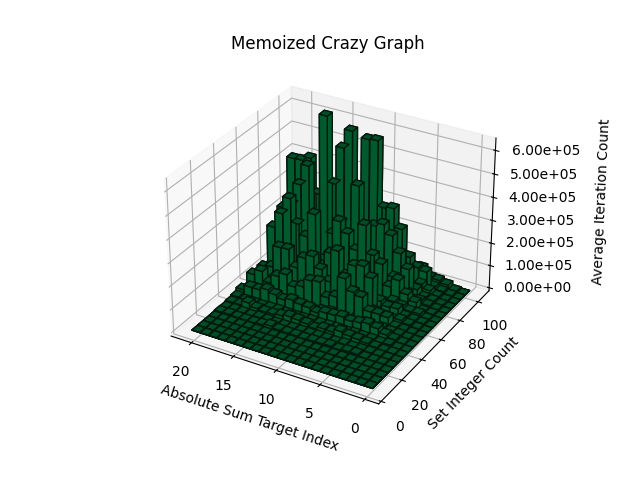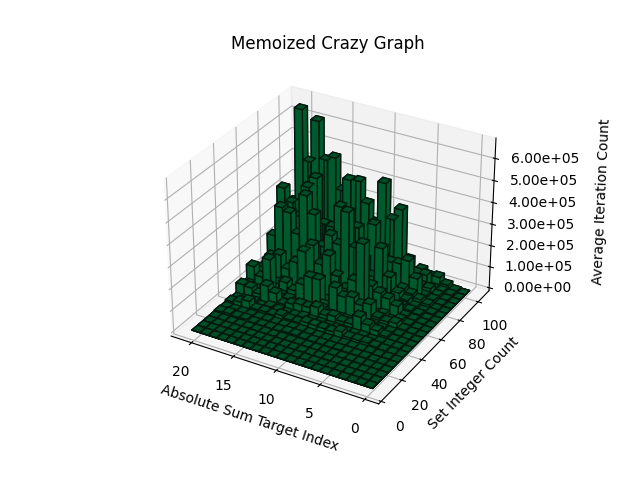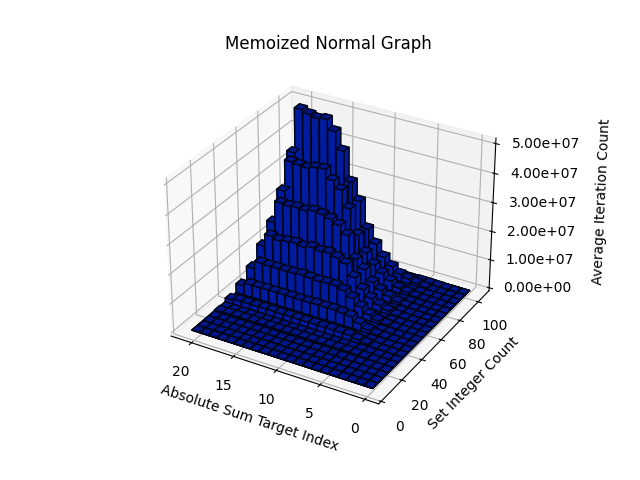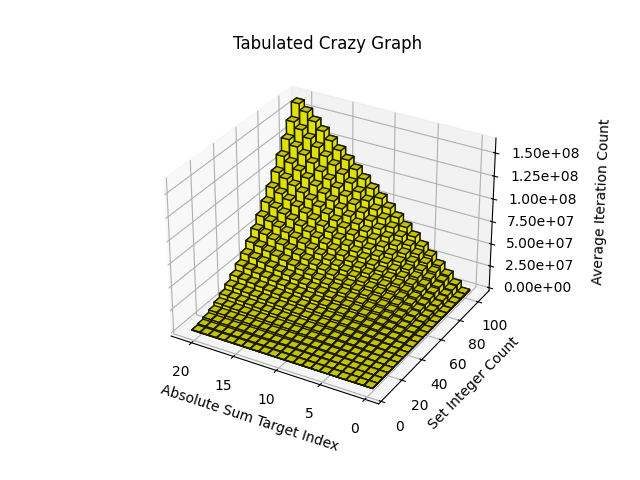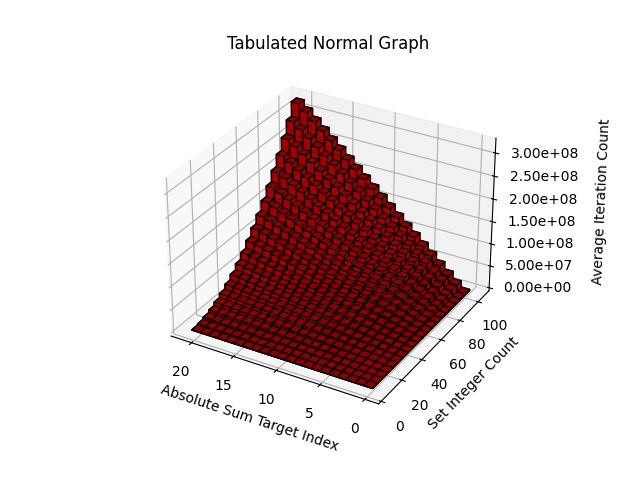

# Part 2: Literature Review

While my dataset has never been experimented on, overall it's a decently simple idea so I looked for papers regarding Neural Networks that were given full factorial data to train on.

[The first one](https://github.com/bananathrowingmachine/UniProj-OpenEndedDeepLearning/blob/main/SMPracticeThoery2004.pdf) is:
Alam, F. M., McNaught, K. R., & Ringrose, T. J. (2004). A comparison of experimental designs in the development of a neural network simulation metamodel. *Simulation Modelling Practice and Theory*, 12(7-8), 559–578. https://doi.org/10.1016/j.simpat.2003.10.006 and is an old study about what experiment designs are best used to train Neural Networks. While more focused on the experiment design itself, I can still get valuable insights into what they used as their Neural Network. Overall the methodology for this paper was to obtain simulated Input-Output data, develop empirical ANN Metamodels, then use it for predicition. Since the methodology is more focused on generating different experiment designs there isn't too much for me here, however it does note that the fully factorial design is actually not the best for Neural Networks which is very interesting. What's far more helpful for me in this study is their Network layout, which was a MLP with 5 nodes in the hidden layer, which was what preformed best, and that's additionally notable as this experiment used 4 features just like mine, and then trained with backpropogation.

[The second one](https://github.com/bananathrowingmachine/UniProj-OpenEndedDeepLearning/blob/main/Multilayer_perceptron_and_neural_network.pdf) is: Popescu, M. C., Balas, V. E., Perescu-Popescu, L., & Mastorakis, N. (2009). Multilayer perceptron and neural networks. *WSEAS Transactions on Circuits and Systems*, 8(7), 579-588. This paper is a lot more about a standard MLP implementation, with some helpful details on how exactly to create a MLP. It's methodology is rather simple, where it compares how a fuzzy controller and nueral controller solve the same problem of induction driving, where it is trained on the control surface of the existing fuzzy controller. The implementation the paper came up with is 4-layer, feed forward, and uses sigmoid functions because they are non-linear and differenciable.

# Part 3: Implement networks in PyTorch

Note of warning here: Depending on how easily you can allocate GPU resources, you may want to make your network much shallower so that you can train it more easily
Aim to have one gradient update take no more than a few seconds
May also want to reduce the number of training steps if training is too slow

In [5]:
class FullyConnectedNN(nn.Module):
    def __init__(self, inputSize, hiddenSizes, outputSize):
        super(FullyConnectedNN, self).__init__()
        layers = []
        currSize = inputSize
        for nextSize in hiddenSizes:
          layers.extend([nn.Linear(currSize, nextSize), nn.ReLU()])
          currSize = nextSize
        layers.append(nn.Linear(currSize, outputSize))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

hiddenSizes = [5, 3]
learningRate = 0.001
criterion = nn.L1Loss() # Chosen due to how large and noisy y can get, I don't want to penalize misses too much
epochs = 10000

In [6]:
def train_model(model, x_train, y_train, x_val, y_val, epochs, speak=True):
    trainAcc = []
    valAcc = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        trainLoss = criterion(y_pred, y_train)
        trainLoss.backward()
        optimizer.step()
        model.eval()

        with torch.no_grad():
            y_pred_val = model(x_val)
            valLoss = criterion(y_pred_val, y_val)

        if speak and (epoch + 1) % (epochs / 20) == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {trainLoss.item():.5f}, Validation Loss: {valLoss.item():.5f}")
        trainAcc.append(trainLoss.item())
        valAcc.append(valLoss.item())

    return trainAcc, valAcc

In [6]:
model = FullyConnectedNN(x_train.shape[1], hiddenSizes, 1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learningRate)
trainAcc, valAcc = train_model(model, x_train, y_train, x_val, y_val, epochs)

Epoch 500/10000, Train Loss: 12.40495, Validation Loss: 12.42797
Epoch 1000/10000, Train Loss: 3.34548, Validation Loss: 3.33877
Epoch 1500/10000, Train Loss: 1.18697, Validation Loss: 1.16925
Epoch 2000/10000, Train Loss: 1.18417, Validation Loss: 1.15876
Epoch 2500/10000, Train Loss: 1.18398, Validation Loss: 1.15811
Epoch 3000/10000, Train Loss: 1.18378, Validation Loss: 1.15777
Epoch 3500/10000, Train Loss: 1.18358, Validation Loss: 1.15770
Epoch 4000/10000, Train Loss: 1.18338, Validation Loss: 1.15795
Epoch 4500/10000, Train Loss: 1.18297, Validation Loss: 1.15783
Epoch 5000/10000, Train Loss: 1.18247, Validation Loss: 1.15843
Epoch 5500/10000, Train Loss: 1.18181, Validation Loss: 1.15995
Epoch 6000/10000, Train Loss: 1.18037, Validation Loss: 1.15994
Epoch 6500/10000, Train Loss: 1.16834, Validation Loss: 1.15872
Epoch 7000/10000, Train Loss: 1.16145, Validation Loss: 1.15294
Epoch 7500/10000, Train Loss: 1.16014, Validation Loss: 1.15134
Epoch 8000/10000, Train Loss: 1.15971, 

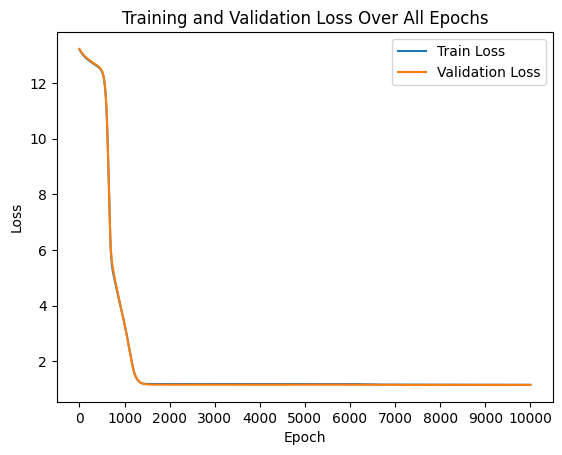

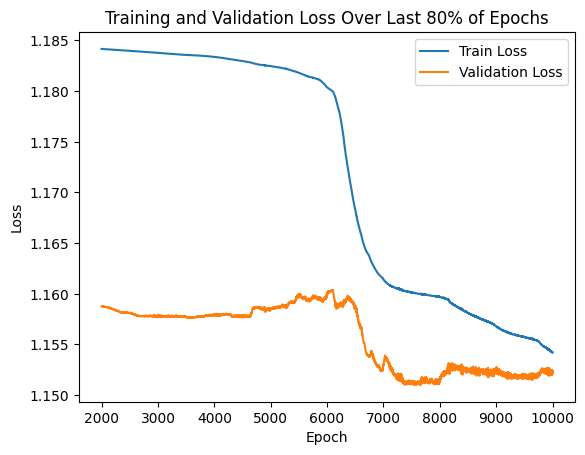

In [7]:
plt.plot(range(epochs), trainAcc, label='Train Loss')
plt.plot(range(epochs), valAcc, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(0, int(epochs * 1.1), int(epochs / 10)))
plt.title('Training and Validation Loss Over All Epochs')
plt.show()

epochPercentage = 0.8
cutoff = int(epochs * (1 - epochPercentage) + 1)
plt.plot(range(cutoff, epochs), trainAcc[cutoff:], label='Train Loss')
plt.plot(range(cutoff, epochs), valAcc[cutoff:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(cutoff, int(epochs * 1.1), int(epochs / 10)))
plt.title(f'Training and Validation Loss Over Last {int(epochPercentage * 100)}% of Epochs')
plt.show()

# Part 4: Run Hyperparameter Experiments

**Hyperparameter Test 1:**

For this test I am attempting to find the best internal layout (with a maximum of 3 layers in the hidden layer and a maximum of 9 nodes per layer). To test every possibility I made an array that starts off with an empty array (which the MLP model will interpret as no hidden layers, or just a regular perceptron), then takes each number in range(1000), converts it to a string, and if that number does not contain a '0' digit, appends it to the list.

To keep it consistent I am using the hidden layer layout of part 3 for this.

In [8]:
# static hyperparameters for this test
learningRate = 0.001
epochs = 10000

# all combos of the tested hyperparameters for this test
realTestLayers = [[]]
visualTestLayers = [[0, 0]]
for i in range(100):
  string = str(i)
  if '0' not in string:
    if len(string) < 2:
      visualString = (string + '0' * (2 - len(string)))
      visualTestLayers.append([int(d) for d in visualString])
    else:
      visualTestLayers.append([int(d) for d in string])
    realTestLayers.append([int(d) for d in string])

accuracy = []
for i, layers in enumerate(realTestLayers):
  model = FullyConnectedNN(x_train.shape[1], layers, 1)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=learningRate)
  criterion = nn.L1Loss()

  trainAcc, valAcc = train_model(model, x_train, y_train, x_val, y_val, epochs, speak=False)
  accuracy.append(valAcc[-1])
  print(f'Test for hidden layout {visualTestLayers[i]} completed with loss {accuracy[-1]:.5f}.')

Test for hidden layout [0, 0] completed with loss 2.13008.
Test for hidden layout [1, 0] completed with loss 1.18418.
Test for hidden layout [2, 0] completed with loss 1.18418.
Test for hidden layout [3, 0] completed with loss 1.18410.
Test for hidden layout [4, 0] completed with loss 1.18394.
Test for hidden layout [5, 0] completed with loss 0.87031.
Test for hidden layout [6, 0] completed with loss 1.18383.
Test for hidden layout [7, 0] completed with loss 0.80424.
Test for hidden layout [8, 0] completed with loss 1.09213.
Test for hidden layout [9, 0] completed with loss 1.18403.
Test for hidden layout [1, 1] completed with loss 1.18391.
Test for hidden layout [1, 2] completed with loss 1.18393.
Test for hidden layout [1, 3] completed with loss 1.08860.
Test for hidden layout [1, 4] completed with loss 1.04568.
Test for hidden layout [1, 5] completed with loss 3.66196.
Test for hidden layout [1, 6] completed with loss 3.66196.
Test for hidden layout [1, 7] completed with loss 1.1840

Best validation loss was: 0.6839630007743835 which came from layer loadout: [9, 2].


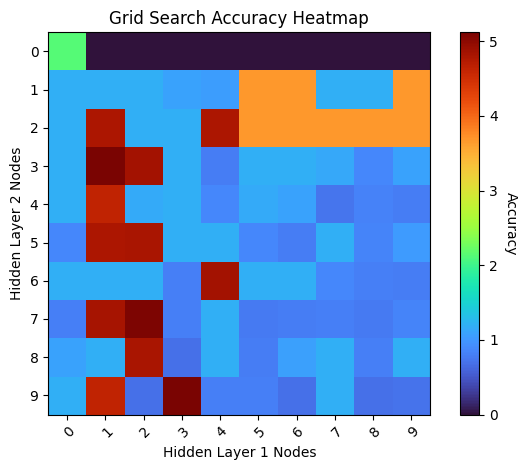

In [9]:
best = min(accuracy)
print(f'Best validation loss was: {best} which came from layer loadout: {visualTestLayers[accuracy.index(best)]}.')

accuracyGrid = np.empty((10, 10))
for i, layers in enumerate(visualTestLayers):
  accuracyGrid[layers[0]][layers[1]] = accuracy[i]
fig, ax = plt.subplots()
im = ax.imshow(accuracyGrid, cmap='turbo')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Accuracy', rotation=-90, va="bottom")
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(10))
ax.set_xlabel("Hidden Layer 1 Nodes")
ax.set_ylabel("Hidden Layer 2 Nodes")
ax.set_title("Grid Search Accuracy Heatmap")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.tight_layout()
plt.show()

**Hyperparameter Test 2:**

For this test I am playing around with other hyperparameters, specifically epochs and learning rate.

Since the final test accuracy will be using the results of both grid searches, I will using the best layer loudout from above to test the epochs and learning rate on.

In [10]:
# static hyperparameters for this test
bestLayers = realTestLayers[accuracy.index(best)]

# all combos of the tested hyperparameters for this test (much simplier because I don't have to worry about a 0 layer)
epochsList = [i for i in range(1000, 16000, 1000)]
learningRatesList = [1/(10 ** i) for i in range(7)]

accuracy = np.empty((len(epochsList), len(learningRatesList)))
for i, epochs in enumerate(epochsList):
  for j, learningRate in enumerate(learningRatesList):
    model = FullyConnectedNN(x_train.shape[1], bestLayers, 1)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
    criterion = nn.L1Loss()
    trainAcc, valAcc = train_model(model, x_train, y_train, x_val, y_val, epochs, speak=False)
    accuracy[i][j] = valAcc[-1]
    print(f'Test for epoch count {epochs} and learning rate {learningRate} completed with loss {valAcc[-1]:.5f}.')

Test for epoch count 1000 and learning rate 1.0 completed with loss 3.66185.
Test for epoch count 1000 and learning rate 0.1 completed with loss 3.66193.
Test for epoch count 1000 and learning rate 0.01 completed with loss 1.18402.
Test for epoch count 1000 and learning rate 0.001 completed with loss 2.57556.
Test for epoch count 1000 and learning rate 0.0001 completed with loss 12.72203.
Test for epoch count 1000 and learning rate 1e-05 completed with loss 13.23015.
Test for epoch count 1000 and learning rate 1e-06 completed with loss 13.36075.
Test for epoch count 2000 and learning rate 1.0 completed with loss 3.66185.
Test for epoch count 2000 and learning rate 0.1 completed with loss 3.66193.
Test for epoch count 2000 and learning rate 0.01 completed with loss 0.87042.
Test for epoch count 2000 and learning rate 0.001 completed with loss 1.13260.
Test for epoch count 2000 and learning rate 0.0001 completed with loss 12.85520.
Test for epoch count 2000 and learning rate 1e-05 comple

Best validation loss was: 0.6750691533088684 which came from epoch count: 13000 and learning rate: 0.1.


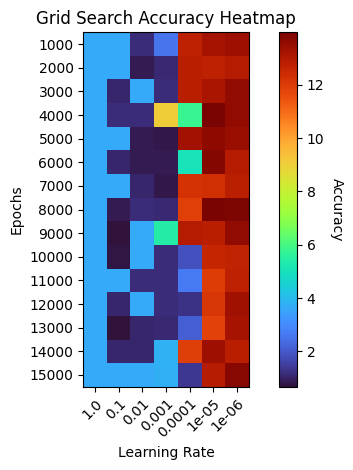

In [11]:
best = np.min(accuracy)
bestEpochsIndex, bestLearningRateIndex = np.where(accuracy == best)
bestEpochs = epochsList[bestEpochsIndex[0]]
bestLR = learningRatesList[bestLearningRateIndex[0]]
print(f'Best validation loss was: {best} which came from epoch count: {bestEpochs} and learning rate: {bestLR}.')

fig, ax = plt.subplots()
im = ax.imshow(accuracy, cmap='turbo')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Accuracy', rotation=-90, va="bottom")
ax.set_yticks(np.arange(len(epochsList)))
ax.set_xticks(np.arange(len(learningRatesList)))
ax.set_yticklabels(epochsList)
ax.set_xticklabels(learningRatesList)
ax.set_ylabel("Epochs")
ax.set_xlabel("Learning Rate")
ax.set_title("Grid Search Accuracy Heatmap")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.tight_layout()
plt.show()

**Data Replication Test:**

One of the more interesting aspects of my data is that the experiment has a fully factorial design and that I am using data from when the test was run twice, which means in the entire set of data each combination of features shows up exactly twice, which helps a lot with accounting for noise. Therefore, what if I was to remove that?

This test will take the "run1" and "run2" arrays, normalize and split them, then using the optimal hyperparameters from above, train a model using one of the 3 subsets of data, and then calculate the loss from inputting the test data from each subset.

Due note I use the test data because the results of this experiment won't change my model, I'm just interested in how it reacts to only getting some data.

In [11]:
bestLayers = [9, 2]
bestEpochs = 13000
bestLR = 0.1

options = [[x_train, y_train, x_val, y_val, x_test, y_test], tripleSplit(normalizeData(run1)), tripleSplit(normalizeData(run2))]
models = [FullyConnectedNN(x_train.shape[1], bestLayers, 1).to(device) for _ in range(3)]
criterion = nn.L1Loss()
testLoss = np.empty((3, 3))
textSubs = ['all of the', 'the run 1', 'the run 2']
print(f'Using model with layers: {bestLayers}, a learning rate of: {bestLR} and epoch count of {bestEpochs}.')
for i in range(3):
  optimizer = optim.Adam(models[i].parameters(), lr=bestLR)
  trainAcc, valAcc = train_model(models[i], options[i][0], options[i][1], options[i][2], options[i][3], bestEpochs, speak=False)
  print(f'Validation loss for model trained with {textSubs[i]} train data is {valAcc[-1]:.5f}.')
  for j in range(3):
    with torch.no_grad():
      y_pred_val = models[i](options[j][2])
      y_pred_test = models[i](options[j][4])
      testLoss[i][j] = criterion(y_pred_test, options[j][5])
      print(f'Model trained with {textSubs[i]} data got a validation loss of {criterion(y_pred_val, options[j][3]):.5f} and a test loss of {testLoss[i][j]:.5f} against {textSubs[j]} data.')

Using model with layers: [9, 2], a learning rate of: 0.1 and epoch count of 13000.
Validation loss for model trained with all of the train data is 0.61945.
Model trained with all of the data got a validation loss of 0.61945 test loss of 0.67185 against all of the data.
Model trained with all of the data got a validation loss of 0.57754 test loss of 0.62411 against the run 1 data.
Model trained with all of the data got a validation loss of 0.57574 test loss of 0.60204 against the run 2 data.
Validation loss for model trained with the run 1 train data is 3.40557.
Model trained with the run 1 data got a validation loss of 3.66246 test loss of 3.41484 against all of the data.
Model trained with the run 1 data got a validation loss of 3.40557 test loss of 3.57339 against the run 1 data.
Model trained with the run 1 data got a validation loss of 3.38566 test loss of 3.57578 against the run 2 data.
Validation loss for model trained with the run 2 train data is 1.05399.
Model trained with the 

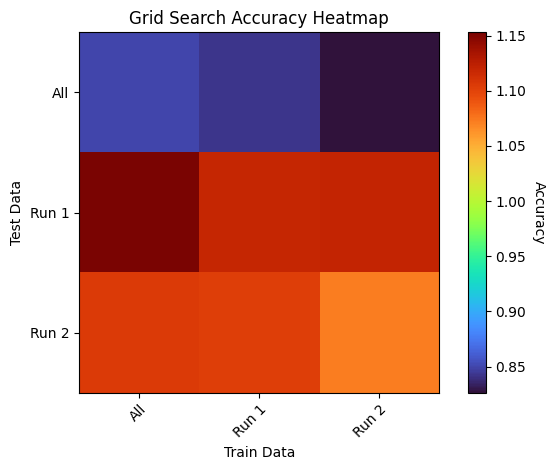

In [23]:
names = ['All', 'Run 1', 'Run 2']

fig, ax = plt.subplots()
im = ax.imshow(testLoss, cmap='turbo')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Accuracy', rotation=-90, va="bottom")
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(names)
ax.set_yticklabels(names)
ax.set_xlabel("Train Data")
ax.set_ylabel("Test Data")
ax.set_title("Grid Search Accuracy Heatmap")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.tight_layout()
plt.show()

**Final Accuracy:**

Due to calculating it above already, as it comes from the model trained with all data that had it's accuracy tested by all data, I will just print it below, along with 10 sets of features, what it predicted, and what the actual value was.

In [14]:
print(f'The final accuracy of the model against the test data is: {testLoss[0][0]}.\n')
print('Example Normalized Rows: (same rows as seen in the data statistics part)')
print('Memoized Flag (x_0) | Crazy Flag (x_1) | Sum Target Index (x_2) | Integer Count (x_3) | Actual Iteration Count (y) | Predicted Iteration Count (y_pred) | L1 Loss')
chosenRows = normalizedDataArray[choices]
with torch.no_grad():
  y_pred_final = models[0](torch.from_numpy(chosenRows[:, :4]).to(device=device, dtype=torch.float32)).cpu().numpy()
print(f'{np.hstack([chosenRows, y_pred_final, np.abs(chosenRows[:, 4:5] - y_pred_final)])}\n')
print('Example Unnormalized Rows: (same rows sent through the reverse of the normalizer functions)')
print('Memoized Flag (x_0) | Crazy Flag (x_1) | Sum Target Index (x_2) | Integer Count (x_3) | Actual Iteration Count (y) | Predicted Iteration Count (y_pred)')
print(np.hstack([chosenRows[:, 0:2], chosenRows[:, 2:3] * 20.0, chosenRows[:, 3:4] * 95 + 5, np.expm1(chosenRows[:, 4:5]), np.expm1(y_pred_final)]))

The final accuracy of the model against the test data is: 0.671854555606842.

Example Normalized Rows: (same rows as seen in the data statistics part)
Memoized Flag (x_0) | Crazy Flag (x_1) | Sum Target Index (x_2) | Integer Count (x_3) | Actual Iteration Count (y) | Predicted Iteration Count (y_pred) | L1 Loss
[[ 0.       1.       0.05     0.68421 15.21707 15.13567  0.08141]
 [ 0.       0.       0.2      0.94737 17.89784 18.00346  0.10562]
 [ 0.       0.       0.05     0.21053 13.83957 13.27682  0.56274]
 [ 1.       0.       0.25     0.10526 10.10061  8.05944  2.04117]
 [ 1.       1.       0.35     0.47368  9.06054  9.82663  0.76609]
 [ 1.       1.       1.       0.15789  6.35437  6.54704  0.19267]
 [ 0.       0.       0.85     0.42105 17.84745 17.83191  0.01554]
 [ 0.       1.       0.2      0.73684 16.7292  16.95756  0.22836]
 [ 0.       1.       0.15     0.68421 16.30587 16.5282   0.22233]
 [ 1.       0.       0.65     0.26316 10.14116 11.10701  0.96585]]

Example Unnormalized Rows

**Predicted Graphs:**

Using the MLP model that has been finalized by the hyperparameter tests, I will finish off by generating the same set of graphs (although I'll only make 1 graph for the 'Memoized Crazy' algorithm). To make sure everything is consistent, I pulled the code to generate the files directly from the repository where it is stored.

Do note this is a lot of me just messing around with Python for the fun of it, I doubt this final section is super relevant to the assignment.

In [12]:
import requests, os, sys
from shutil import rmtree
from pathlib import Path

os.chdir('/content')
if Path('/content/data_processing_code').exists():
    rmtree('/content/data_processing_code')
os.makedirs('data_processing_code')
for fileName in ['MainDataProcessor', 'MiscDataCode']:
    response = requests.get(f"https://github.com/bananathrowingmachine/FastPartitionExperiment/blob/main/data_processing_code/{fileName}.py?raw=true")
    with open(f'data_processing_code/{fileName}.py', 'w') as f:
        f.write(response.text)
sys.path.append('/content')

from data_processing_code.MainDataProcessor import MainDataProcessor #type: ignore
from data_processing_code.MiscDataCode import ResultsWrapper, DataProcessingInfo, MachinePredResultsDType #type: ignore

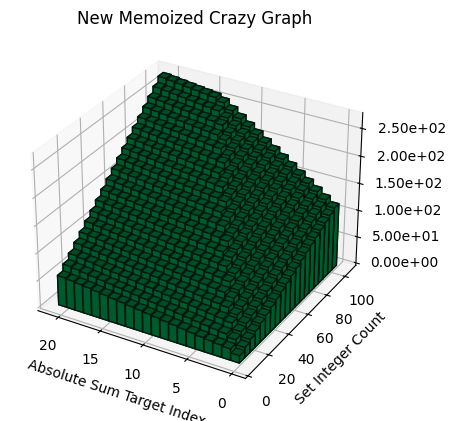

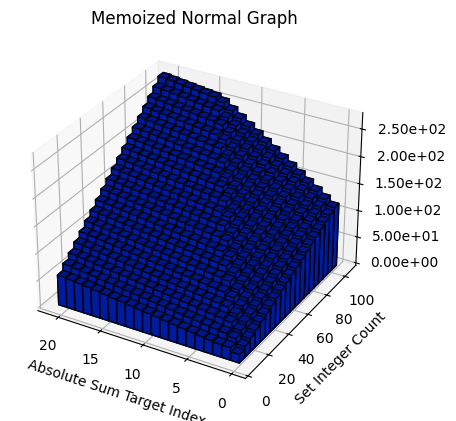

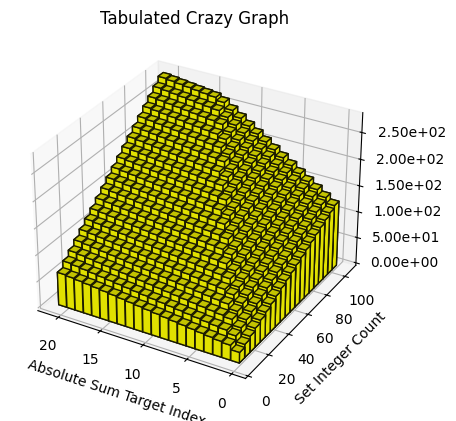

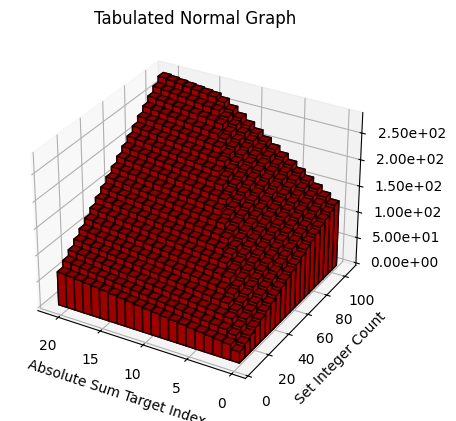

In [13]:
DataProcessor = MainDataProcessor(None, (False, True, False, True, True, True, False))
for n in range(1, 21):
  size = n * 5
  results = np.empty(21, dtype=MachinePredResultsDType)
  staticFeatures = np.column_stack([[i for i in range(21)], [size for _ in range(21)]])
  with torch.no_grad():
    inputs = np.column_stack([np.ones((21,)), np.ones((21,)), staticFeatures])
    results['newMemoCrazy'] = models[0](torch.from_numpy(inputs).to(device=device, dtype=torch.float32)).cpu().numpy().squeeze()
    inputs = np.column_stack([np.ones((21,)), np.zeros((21,)), staticFeatures])
    results['memoNormal'] = models[0](torch.from_numpy(inputs).to(device=device, dtype=torch.float32)).cpu().numpy().squeeze()
    inputs = np.column_stack([np.zeros((21,)), np.ones((21,)), staticFeatures])
    results['tabCrazy'] = models[0](torch.from_numpy(inputs).to(device=device, dtype=torch.float32)).cpu().numpy().squeeze()
    inputs = np.column_stack([np.zeros((21,)), np.zeros((21,)), staticFeatures])
    results['tabNormal'] = models[0](torch.from_numpy(inputs).to(device=device, dtype=torch.float32)).cpu().numpy().squeeze()
  wrappedResults = ResultsWrapper(size, None, results)
  DataProcessor.appendData(wrappedResults)
for figure in DataProcessor.outputImageData():
  plt.show()